## CIFAR-10 图像分类：初步实现

本笔记旨在记录使用 PyTorch 构建卷积神经网络 (CNN) 完成 CIFAR-10 图像分类任务的完整流程。重点在于理解并实现包括数据加载、预处理、模型构建（特别是深度可分离卷积的应用）、训练、评估及结果可视化等关键环节。

### 1. 导入所需库

首先，导入研究所需的 Python 库。核心库包括 `torch` (PyTorch 深度学习框架)，`torchvision` (处理计算机视觉任务，包含数据集、模型和图像变换)，`matplotlib` (用于绘图)，以及 `sklearn.metrics` (用于计算混淆矩阵)。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns # 用于更美观的混淆矩阵可视化

# 用于在 Notebook 中显示 matplotlib 图像
%matplotlib inline

### 2. 设备配置与超参数设定

检查 CUDA 是否可用，以决定使用 GPU 还是 CPU 进行训练。同时，定义一些关键的超参数，如学习率、批次大小和训练周期数。这些参数后续可进行调整以优化模型性能。

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"当前使用的设备是: {device}")

# 定义超参数
LEARNING_RATE = 0.001
BATCH_SIZE = 64 # 初始批次大小，可根据显存调整
EPOCHS = 50      # 初始训练周期，后续可增加

# CIFAR-10 类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

当前使用的设备是: cuda:0


### 3. 数据加载、预处理与增强

此步骤涉及 CIFAR-10 数据集的加载与准备。关键操作包括：
1.  **数据变换 (Transforms):** 定义一系列针对训练集和测试集的预处理操作。
    *   `ToTensor()`: 将 PIL 图像或 NumPy `ndarray` 转换为 `FloatTensor`，并将图像的像素值范围从 [0, 255] 归一化到 [0.0, 1.0]。
    *   `Normalize(mean, std)`: 用给定的均值 (mean) 和标准差 (std) 对张量图像进行归一化。此操作有助于加速模型收敛并提高稳定性。CIFAR-10 数据集常用的均值和标准差为 `(0.4914, 0.4822, 0.4465)` 和 `(0.2023, 0.1994, 0.2010)`，参考[https://stackoverflow.com/a/68123869/29793656](https://stackoverflow.com/a/68123869/29793656)
    *   **数据增强 (Data Augmentation):** 仅对训练集应用，以增加数据多样性，提高模型泛化能力。例如 `RandomHorizontalFlip()` (随机水平翻转) 和 `RandomCrop()` (随机裁剪)等。
2.  **数据集下载与加载:** 使用 `torchvision.datasets.CIFAR10` 下载并加载数据集。
3.  **数据加载器 (DataLoader):** 使用 `torch.utils.data.DataLoader` 创建数据加载器，以便在训练和测试过程中高效地批量加载数据，并支持数据打乱 (`shuffle=True` for training)。

In [4]:
# 定义训练集的数据增强和预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 随机水平翻转
    transforms.RandomHorizontalFlip(), # 随机裁剪
    transforms.RandomRotation(15), # 随机旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 颜色抖动
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 测试集的 transform_test 通常保持不变
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 加载 CIFAR-10 训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2) # num_workers用于多进程加载数据

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

print(f"训练集样本数: {len(trainset)}")
print(f"测试集样本数: {len(testset)}")

100%|██████████| 170498071/170498071 [00:15<00:00, 11268536.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
训练集样本数: 50000
测试集样本数: 10000


### 4. 模型定义 (卷积神经网络与深度可分离卷积)

#### 4.1 自己定义的网络

构建卷积神经网络模型。根据要求，模型需包含**深度可分离卷积 (Depthwise Separable Convolution)**。深度可分离卷积将标准卷积分解为两个步骤：
1.  **深度卷积 (Depthwise Convolution):** 对每个输入通道独立应用一个卷积核。通过 `nn.Conv2d` 的 `groups` 参数实现，当 `groups` 等于输入通道数 `in_channels` 时，即为深度卷积。
2.  **逐点卷积 (Pointwise Convolution):** 一个标准的 1x1 卷积，用于组合深度卷积产生的特征图，并调整通道数。

首先定义一个深度可分离卷积模块，然后将其集成到主网络结构中。网络结构可以包含若干卷积层、深度可分离卷积层、激活函数 (如 ReLU)、池化层 (如 MaxPool2d) 和全连接层。

In [5]:
class DepthwiseSeparableConv(nn.Module):
    """深度可分离卷积模块"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        # 深度卷积: groups=in_channels 使得每个输入通道独立进行卷积
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   stride=stride, padding=padding, groups=in_channels, bias=False)
        self.bn_depthwise = nn.BatchNorm2d(in_channels) # 在深度卷积后接BN
        # 逐点卷积: 1x1 卷积
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn_pointwise = nn.BatchNorm2d(out_channels) # 在逐点卷积后接BN

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn_depthwise(x)
        x = F.relu(x) # 激活函数
        x = self.pointwise(x)
        x = self.bn_pointwise(x)
        x = F.relu(x) # 激活函数
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 初始卷积层，可以适当增加初始通道数
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        
        # 第一个深度可分离卷积层，增加输出通道
        self.dsc1 = DepthwiseSeparableConv(48, 96, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 Max Pooling
        self.dropout1 = nn.Dropout(0.25) # Dropout层防止过拟合

        # 第二个深度可分离卷积层，增加输出通道
        self.dsc2 = DepthwiseSeparableConv(96, 192, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # 第三个深度可分离卷积层，增加输出通道
        self.dsc3 = DepthwiseSeparableConv(192, 384, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        
        # 全连接层
        # 输入尺寸计算: 初始32x32 -> pool1后16x16 -> pool2后8x8 -> pool3后4x4
        # 因此，flatten后的特征数量为 384 * 4 * 4
        self.fc1 = nn.Linear(384 * 4 * 4, 512) 
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10) # CIFAR-10 有10个类别

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.dsc1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.dsc2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.dsc3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = x.view(-1, 384 * 4 * 4) # Flatten操作
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x) # 输出层不需要激活函数，因为CrossEntropyLoss会处理
        return x

model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dsc1): DepthwiseSeparableConv(
    (depthwise): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
    (bn_depthwise): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pointwise): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn_pointwise): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dsc2): DepthwiseSeparableConv(
    (depthwise): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
    (bn_depthwise): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pointwise): Conv2d(96, 192, ker

#### 以下是该模型的网络架构图：

In [6]:
import uuid

class Mermaid:
    def __init__(self, diagram: str):
        self._diagram = self._process_diagram(diagram)
        self._uid = uuid.uuid4()

    @staticmethod
    def _process_diagram(diagram: str) -> str:
        _diagram = diagram.replace("\n", "\\n")
        _diagram = _diagram.lstrip("\\n")
        _diagram = _diagram.replace("'", '"')
        return _diagram

    def _repr_html_(self) -> str:
        ret = f"""
        <div class="mermaid-{self._uid}" style="background-color: white;"></div>
        <script type="module">
            import mermaid from 'https://cdn.jsdelivr.net/npm/mermaid@10.1.0/+esm'
            const graphDefinition = '{self._diagram}';
            const element = document.querySelector('.mermaid-{self._uid}');
            const {{ svg }} = await mermaid.render('graphDiv-{self._uid}', graphDefinition);
            element.innerHTML = svg;
        </script>
        """
        return ret

Mermaid("""
graph LR
    A--> B
""")

#### 4.2 另一种方案

以上模型在测试集上的准确率已经可以达到 80% 了，但为了追求更高的准确率并采用更复杂的模型结构，我们可以选用 `ResNet-18` 架构。ResNet 通过引入残差学习单元，有效解决了深度神经网络训练中的梯度消失和网络退化问题，使得构建和训练更深层次的网络成为可能。

我们优先使用自己定义的网络进行训练，随后尝试 ResNet-18 网络架构，**其结果将附在最后**。

### 5. 定义损失函数与优化器

对于多分类任务，常用的损失函数是**交叉熵损失 (Cross-Entropy Loss)**，在 PyTorch 中通过 `nn.CrossEntropyLoss()` 实现。该损失函数内部集成了 `LogSoftmax` 和 `NLLLoss`，因此模型输出层通常不需要显式添加 Softmax激活函数。

选择**优化器 (Optimizer)** 来更新模型的权重。Adam 优化器 (`optim.Adam`) 是一种常用的自适应学习率优化算法，通常具有较好的性能。

为进一步优化学习过程，我们可以采用余弦退火学习率调度器 (`torch.optim.lr_scheduler.CosineAnnealingLR`)。该调度器依据余弦函数曲线，在指定的周期 (`T_max`) 内将学习率从初始值**平滑地**降低至一个设定的最小值 (`eta_min`)。这种策略有助于模型在训练后期更稳定地收敛，从而达到更优的性能。

In [7]:
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam优化器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0.00001) # 

### 6. 训练模型

训练过程在一个循环中进行，每个循环代表一个**训练周期 (Epoch)**。在每个周期内，模型遍历整个训练数据集。
对于每个批次 (Batch) 的数据：
1.  将数据和标签移动到指定设备 (GPU/CPU)。
2.  **梯度清零:** `optimizer.zero_grad()`，清除上一轮迭代的梯度信息。
3.  **前向传播:** `outputs = model(inputs)`，将输入数据送入模型，得到预测输出。
4.  **计算损失:** `loss = criterion(outputs, labels)`，根据预测输出和真实标签计算损失。
5.  **反向传播:** `loss.backward()`，计算损失相对于模型参数的梯度。
6.  **参数更新:** `optimizer.step()`，根据梯度更新模型参数。

在训练过程中，可以记录并打印每个周期的平均训练损失和准确率，以监控训练状态。

In [ ]:
def train_model(model, trainloader, criterion, optimizer, epochs, scheduler=None):
    model.train() # 设置模型为训练模式
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # 乘以batch_size以得到总损失
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            if (i + 1) % 100 == 0: # 每100个mini-batches打印一次信息
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f'Epoch {epoch+1}结束: 平均训练损失: {epoch_loss:.4f}, 训练准确率: {epoch_accuracy:.4f}')
        
        if scheduler:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f'调用学习率调度器， 当前学习率: {current_lr:.6f}')
    
    print('训练完成')
    return train_losses, train_accuracies

# 开始训练
train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, epochs=EPOCHS, scheduler=scheduler)

Epoch [1/50], Step [100/782], Loss: 2.1218
Epoch [1/50], Step [200/782], Loss: 2.1501
Epoch [1/50], Step [300/782], Loss: 1.8411
Epoch [1/50], Step [400/782], Loss: 1.6221
Epoch [1/50], Step [500/782], Loss: 1.8159
Epoch [1/50], Step [600/782], Loss: 1.7682
Epoch [1/50], Step [700/782], Loss: 1.6304
Epoch 1结束: 平均训练损失: 1.9566, 训练准确率: 0.2579
Epoch [2/50], Step [100/782], Loss: 1.8707
Epoch [2/50], Step [200/782], Loss: 1.8378
Epoch [2/50], Step [300/782], Loss: 1.8421
Epoch [2/50], Step [400/782], Loss: 1.5221
Epoch [2/50], Step [500/782], Loss: 1.5763
Epoch [2/50], Step [600/782], Loss: 1.9407
Epoch [2/50], Step [700/782], Loss: 1.8492
Epoch 2结束: 平均训练损失: 1.7329, 训练准确率: 0.3279
Epoch [3/50], Step [100/782], Loss: 1.6027
Epoch [3/50], Step [200/782], Loss: 1.7028
Epoch [3/50], Step [300/782], Loss: 1.5826
Epoch [3/50], Step [400/782], Loss: 1.5446
Epoch [3/50], Step [500/782], Loss: 1.2773
Epoch [3/50], Step [600/782], Loss: 1.6447
Epoch [3/50], Step [700/782], Loss: 1.6416
Epoch 3结束: 平均训练

### 7. 评估模型

在模型训练完成后，使用测试数据集评估其性能。评估过程与训练类似，但不进行梯度计算和参数更新。
1.  将模型设置为评估模式: `model.eval()`。这会关闭 Dropout 和 BatchNorm 的更新等特定于训练的行为。
2.  使用 `torch.no_grad()` 上下文管理器，禁用梯度计算，以减少内存消耗并加速计算。
3.  遍历测试数据加载器，计算总损失和准确率。
4.  收集所有真实标签和预测标签，用于后续的混淆矩阵和样本可视化。

In [8]:
def evaluate_model(model, testloader, criterion):
    model.eval() # 设置模型为评估模式
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # 在评估阶段不计算梯度
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy()) # 收集真实标签
            all_predictions.extend(predicted.cpu().numpy()) # 收集预测标签

    avg_test_loss = test_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    print(f'测试集: 平均损失: {avg_test_loss:.4f}, 准确率: {correct_predictions}/{total_samples} ({accuracy:.2%})')
    return avg_test_loss, accuracy, all_labels, all_predictions

# 评估模型
test_loss, test_accuracy, true_labels, pred_labels = evaluate_model(model, testloader, criterion)

测试集: 平均损失: 0.5344, 准确率: 8203/10000 (82.03%)


### 8. 结果可视化

#### 8.1 训练过程可视化 (损失与准确率曲线)
绘制训练过程中的损失和准确率曲线，可以观察模型的收敛情况。

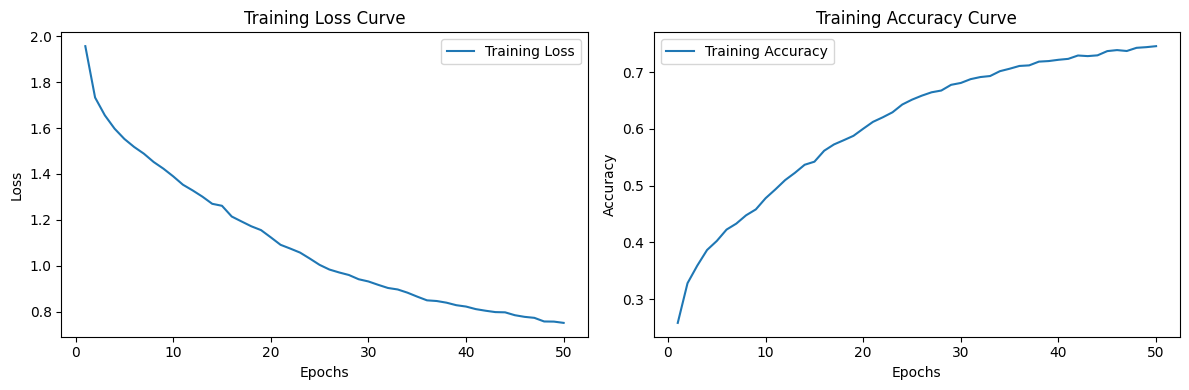

In [9]:
def plot_training_curves(epochs_list, train_losses, train_accuracies, model_name=""):
    """绘制训练过程中的损失和准确率曲线。"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_losses, label=f'{model_name} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, train_accuracies, label=f'{model_name} Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Training Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(range(1, EPOCHS + 1), train_losses, train_accuracies, model_name="Original Model")

#### 8.2 混淆矩阵 (Confusion Matrix)

混淆矩阵清晰地展示了模型在各个类别上的分类情况，特别是哪些类别容易被混淆。使用 `sklearn.metrics.confusion_matrix` 计算，并用 `seaborn.heatmap` 或 `matplotlib.pyplot.imshow` 进行可视化。

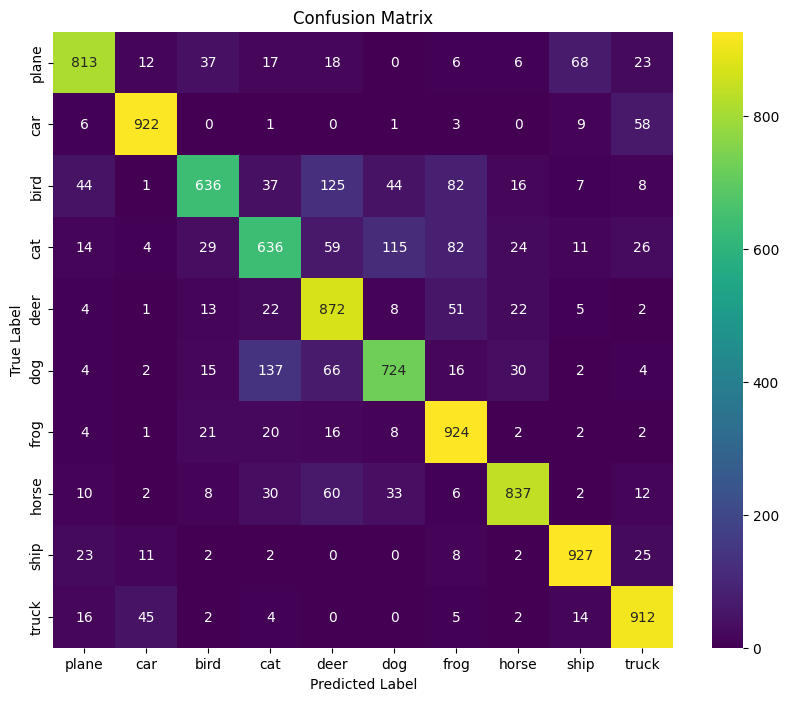

In [10]:
def plot_confusion_matrix_heatmap(true_labels, pred_labels, class_names, model_name=""):
    """绘制混淆矩阵的热力图。"""
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

plot_confusion_matrix_heatmap(true_labels, pred_labels, classes, model_name="Original Model")

#### 8.3 样本图片、真实标签与预测标签展示

随机抽取一部分测试集图片，展示其真实图像、真实标签以及模型的预测标签。这有助于直观感受模型的分类效果。
注意：由于数据加载时进行了归一化，显示图像前需要进行**反归一化**操作，以还原图像的原始像素值范围。

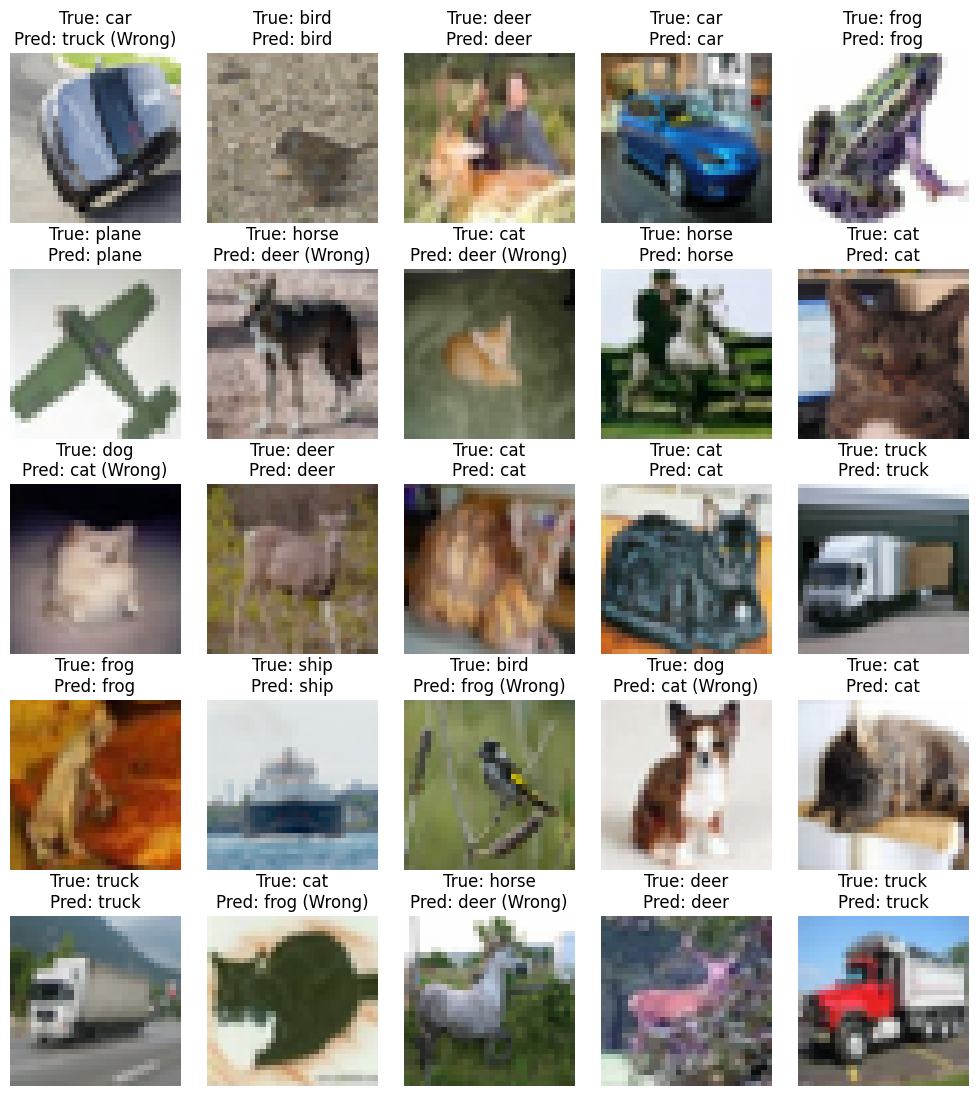

In [11]:
def imshow_with_predictions(img_tensor, title):
    """显示反归一化后的图像及其标题"""
    # 反归一化: PyTorch中的图像是 C x H x W, Matplotlib 需要 H x W x C
    # 均值和标准差 (与预处理时一致)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    
    img_np = img_tensor.numpy().transpose((1, 2, 0)) # C,H,W -> H,W,C
    img_np = std * img_np + mean # 反归一化
    img_np = np.clip(img_np, 0, 1) # 将像素值限制在 [0, 1] 范围内
    
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')

def visualize_sample_predictions(dataset, model_to_eval, current_device, class_names, num_images=25, model_name=""):
    """可视化一部分测试图片的真实标签和预测标签。"""
    model_to_eval.eval()
    
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))
    
    plt.figure(figsize=(cols * 2, rows * 2.2))
    if model_name:
        plt.suptitle(f"Sample Predictions for {model_name}", fontsize=16, y=1.03)

    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        img_tensor, label = dataset[idx] 
        img_for_model = img_tensor.unsqueeze(0).to(current_device) 
        
        with torch.no_grad():
            output = model_to_eval(img_for_model)
            _, predicted_idx = torch.max(output, 1)
        
        predicted_class = class_names[predicted_idx.item()]
        true_class = class_names[label]
        
        plt.subplot(rows, cols, i + 1)
        title_str = f"True: {true_class}\\nPred: {predicted_class}"
        if predicted_class != true_class:
            title_str = f"{title_str} (Wrong)"
        
        imshow_with_predictions(img_tensor.cpu(), title_str) # imshow_with_predictions 内部处理反归一化
        
    plt.tight_layout(rect=[0, 0, 1, 0.99]) # 调整布局以适应主标题
    plt.show()

# 可视化测试集中的预测结果 (注意: testset 包含的是已经 transform 过的图像)
visualize_sample_predictions(testset, model, device, classes, num_images=25, model_name="Original Model")

### 9. 保存模型

训练完成后，可以将模型的**状态字典 (state_dict)** 保存到磁盘。状态字典包含了模型的所有可学习参数 (权重和偏置)。后续可以通过加载此状态字典来恢复模型，进行进一步的训练、评估或部署。
使用 `torch.save(model.state_dict(), PATH)` 保存，使用 `model.load_state_dict(torch.load(PATH))` 和 `model.to(device)` 加载。

In [18]:
MODEL_PATH = 'cifar10_cnn_depthwise_sep.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"模型已保存到: {MODEL_PATH}")

# 如何加载模型 (示例):
# model_loaded = Net().to(device)
# model_loaded.load_state_dict(torch.load(MODEL_PATH))
# model_loaded.eval() # 设置为评估模式

模型已保存到: cifar10_cnn_depthwise_sep.pth


## 进阶模型探索：ResNet-18

在原有模型达到作业要求的基础上，为了进一步提升模型性能并展现对更复杂网络结构的探索，本部分将实现、训练和评估一个基于 **ResNet-18** 架构的图像分类模型。

ResNet (Residual Network) 通过引入“快捷连接” (Shortcut Connections) 或“残差学习” (Residual Learning) 的思想，使得非常深的网络也能够有效地进行训练。我们将从 `torchvision.models` 中加载 ResNet-18 的骨干网络结构，并对其进行适应性修改以用于 CIFAR-10 数据集。

### R1. ResNet-18 模型定义与配置

针对 CIFAR-10 (32x32图像)，对标准的 ResNet-18 进行如下调整：
1.  **修改初始卷积层 `conv1`**: 使用较小的卷积核 (3x3)、步长 (1) 和填充 (1)。
2.  **移除初始最大池化层 `maxpool`**: 通过将其替换为一个恒等映射 (`nn.Identity()`) 来实现，避免特征图尺寸过早过度减小。
3.  **全连接层 `fc`**: 确保其输出维度为 CIFAR-10 的10个类别 (此步骤在加载模型时通过 `num_classes` 参数处理)。

In [8]:
import torchvision.models as models

class ResNet18_CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_CIFAR10, self).__init__()
        self.resnet18 = models.resnet18(weights=None, num_classes=num_classes)

        self.resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet18.maxpool = nn.Identity()

    def forward(self, x):
        return self.resnet18(x)

# 实例化 ResNet-18 模型
model_resnet = ResNet18_CIFAR10(num_classes=len(classes)).to(device)
print("ResNet-18 模型结构:")
print(model_resnet)

total_params_resnet = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
print(f"ResNet-18 模型总参数量: {total_params_resnet:,}")

# 为 ResNet-18 定义新的超参数、优化器和学习率调度器
LEARNING_RATE_RESNET = 0.001 # 可以与原模型相同或独立调整
EPOCHS_RESNET = 100 # ResNet通常需要更多epochs来收敛，先设为100，可根据情况增加
BATCH_SIZE_RESNET = 64 # 可以与原模型相同或独立调整

optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=LEARNING_RATE_RESNET, weight_decay=1e-4) # 添加权重衰减
scheduler_resnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=EPOCHS_RESNET, eta_min=1e-6)

ResNet-18 模型结构:
ResNet18_CIFAR10(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(

### R2. 训练 ResNet-18 模型

使用与之前定义的 `train_model` 函数相同的训练流程，但传入 ResNet-18 模型及其对应的优化器和学习率调度器。

In [20]:
print("开始训练 ResNet-18 模型...")
train_losses_resnet, train_accuracies_resnet = train_model(
    model_resnet, 
    trainloader,
    criterion,
    optimizer_resnet, 
    epochs=EPOCHS_RESNET, 
    scheduler=scheduler_resnet
)

开始训练 ResNet-18 模型...


KeyboardInterrupt: 

### R3. 评估 ResNet-18 模型

使用 `evaluate_model` 函数评估训练好的 ResNet-18 模型在测试集上的性能。

In [ ]:
print("评估 ResNet-18 模型...")
test_loss_resnet, test_accuracy_resnet, true_labels_resnet, pred_labels_resnet = evaluate_model(
    model_resnet, 
    testloader,
    criterion
)

### R4. ResNet-18 结果可视化

使用重构后的可视化函数展示 ResNet-18 的训练曲线、混淆矩阵和样本预测。

In [ ]:
# 1. 训练过程可视化
print("绘制 ResNet-18 训练曲线...")
plot_training_curves(range(1, EPOCHS_RESNET + 1), train_losses_resnet, train_accuracies_resnet, model_name="ResNet-18")

# 2. 混淆矩阵
print("绘制 ResNet-18 混淆矩阵...")
plot_confusion_matrix_heatmap(true_labels_resnet, pred_labels_resnet, classes, model_name="ResNet-18")

# 3. 样本图片、真实标签与预测标签展示
print("可视化 ResNet-18 样本预测...")
visualize_sample_predictions(testset, model_resnet, device, classes, num_images=25, model_name="ResNet-18")

### R5. 保存 ResNet-18 模型

In [ ]:
MODEL_PATH_RESNET = 'cifar10_resnet18.pth'
torch.save(model_resnet.state_dict(), MODEL_PATH_RESNET)
print(f"ResNet-18 模型已保存到: {MODEL_PATH_RESNET}")